# K-mer filtering, 16/04/20

## TODO
- (done) check the entropy measure
- (done) take the difference from query likelihood to the query likelihood given by epa
- (done) implement random filter
- build LL-plots (log-likelihood vs log-likelihood, grouped by query and sorted by value)
- take another pruning of D652
- take not a pruning, but a sparse tree

## Intro

### K-mer score distributions

Here we introduce the concept of a k-mer score distribution.
Let $x$ be a k-mer, $s_b^x$ be the corresponding score of $x$ for the branch $b$, retrieved from the database:

```python
branches = database[x];

if b in branches:
    log_score = branches[b];
else:
    log_score = database.threshold;
    
s_x_b = pow(10, log_score);

```


Then $P_{x} = \{p_0^x, p_1^x, \dots p_n^x\}$ is the score distribution of the k-mer $x$, where $n$ is the number of internal branches of the phylogenetic tree, and

$p_i^x = \frac{s_i^x}{\sum_{j=0}^{n-1}{s_j^x} }$.


Simply saying, we look at the vector of normalized scores of branches for a fixed k-mer (thresholds included).



### Score filters

Score filtering algorithm:


1. For every k-mer $x$:
    1. Take the score distribution of a k-mer.
    2. Calculate the value $F(P_{x})$ of the filter function on the distribution
2. Calculate the threshold value $F_\mu$ of $F(P)$ such as the number of k-mers that have $F(P)$ values more than $F_\mu$ is not less than $\mu$.
3. Store $x$ in the database, if $F(P_x) >= F_\mu$.


Here we think about $\mu$ as the proportion of the "best" k-mers to keep, where what are best determined by the filter function. The tested filter functions are:
- entropy filter
- max deviation filter
- max difference filter


## Entropy filter

This is the classic Shannon entropy on discrete distributions:

$F(P_x) = - \sum_{i=0}^{n}{p_i^x \log(p_i^x)}$


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
workdir = "/home/nikolai/dev/datasets/d652/266_pruning/pewo_likelihood"
filename = f"{workdir}/tables_LL_rappas2.csv"
tables_rappas = pd.read_csv(filename, sep=";")
tables_rappas["software"] = "rappas"
tables_rappas["f"] = "entropy"
tables_rappas.drop(['pruning', 'ar', 'length', 'red'], axis=1, inplace=True)
tables_rappas.head()

,k,o,mu,query,likelihood,software,f
0,10,2.0,0.1,113S1-4-r300-0-300,-41760.711894,rappas,entropy
1,10,2.0,0.1,113S1-4-r300-300-600,-41667.159348,rappas,entropy
2,10,2.0,0.1,113S1-4-r300-600-900,-41712.307100,rappas,entropy
3,10,2.0,0.1,123B-13-F-r300-0-300,-41786.493945,rappas,entropy
4,10,2.0,0.1,123B-13-F-r300-1200-1500,-41792.242213,rappas,entropy


In [3]:
workdir = "/home/nikolai/dev/datasets/d652/266_pruning/pewo_likelihood"
filename = f"{workdir}/tables_LL_epa.csv"
tables_epa = pd.read_csv(filename, sep=";")
tables_epa["software"] = "epa"
tables_epa.drop(['pruning', 'length'], axis=1, inplace=True)
tables_epa.head()

,g,query,likelihood,software
0,0.01,113S1-4-r300-0-300,-41760.711894,epa
1,0.01,113S1-4-r300-300-600,-41665.623969,epa
2,0.01,113S1-4-r300-600-900,-41711.922133,epa
3,0.01,123B-13-F-r300-0-300,-41786.493945,epa
4,0.01,123B-13-F-r300-1200-1500,-41796.585136,epa


In [4]:
workdir = "/home/nikolai/dev/datasets/d652/266_pruning/pewo_likelihood_full"
filename = f"{workdir}/tables_LL_rappas2.csv"
tables_rappas_full = pd.read_csv(filename, sep=";")
tables_rappas_full["software"] = "rappas"
tables_rappas_full.rename(columns={"filter": "f"}, inplace=True)
tables_rappas_full.drop(['pruning', 'ar', 'length', 'red'], axis=1, inplace=True)
tables_rappas_full.head()

,k,o,mu,f,query,likelihood,software
0,10,2.0,1.0,no-filter,113S1-4-r300-0-300,-41760.711894,rappas
1,10,2.0,1.0,no-filter,113S1-4-r300-300-600,-41667.164893,rappas
2,10,2.0,1.0,no-filter,113S1-4-r300-600-900,-41712.307100,rappas
3,10,2.0,1.0,no-filter,123B-13-F-r300-0-300,-41786.493945,rappas
4,10,2.0,1.0,no-filter,123B-13-F-r300-1200-1500,-41792.242213,rappas


In [5]:
workdir = "/home/nikolai/dev/datasets/d652/266_pruning/pewo_likelihood_random"
filename = f"{workdir}/tables_LL_rappas2.csv"
tables_rappas_random = pd.read_csv(filename, sep=";")
tables_rappas_random["software"] = "rappas"
tables_rappas_random["f"] = "random"
tables_rappas_random.drop(['pruning', 'ar', 'length', 'red'], axis=1, inplace=True)
tables_rappas_random.head()

,k,o,mu,filter,query,likelihood,software,f
0,10,2.0,0.1,random,113S1-4-r300-0-300,-41763.900494,rappas,random
1,10,2.0,0.1,random,113S1-4-r300-300-600,-41667.159348,rappas,random
2,10,2.0,0.1,random,113S1-4-r300-600-900,-41712.307100,rappas,random
3,10,2.0,0.1,random,123B-13-F-r300-0-300,-41786.493945,rappas,random
4,10,2.0,0.1,random,123B-13-F-r300-1200-1500,-41792.242213,rappas,random


In [6]:
software_args = {
    "epa" : ["g"],
    "rappas": ["k", "o", "mu", "f"]
}


def fill_software_run(df):
    df["software run"] = ''

    for software in df["software"].unique():
        software_run_column = software
        for arg in software_args[software]:
            software_run_column += "\n" + arg + df[arg].astype(str)

        rows_to_update = df["software"] == software
        df.loc[rows_to_update, "software run"] = software_run_column[rows_to_update]
        
    return df

In [7]:
tables_epa = fill_software_run(tables_epa)
tables_rappas = fill_software_run(tables_rappas)
tables_rappas_random = fill_software_run(tables_rappas_random)
tables_rappas_full = fill_software_run(tables_rappas_full)

In [8]:
def pivot(df):
    return df.pivot(index="query", columns="software run", values="likelihood")

df_epa = pivot(tables_epa)
df_rappas = pivot(tables_rappas)
df_rappas_random = pivot(tables_rappas_random)
df_rappas_full = pivot(tables_rappas_full)
df_rappas_full.head()

software run,rappas\nk10\no2.0\nmu1.0\nfno-filter,rappas\nk8\no2.0\nmu1.0\nfno-filter
query,,
113S1-4-r300-0-300,-41760.711894,-41760.711894
113S1-4-r300-300-600,-41667.164893,-41667.164893
113S1-4-r300-600-900,-41712.307100,-41712.307100
123B-13-F-r300-0-300,-41786.493945,-41786.493945
123B-13-F-r300-1200-1500,-41792.242213,-41792.242213


In [9]:
df_epa.head()

software run,epa\ng0.01
query,
113S1-4-r300-0-300,-41760.711894
113S1-4-r300-300-600,-41665.623969
113S1-4-r300-600-900,-41711.922133
123B-13-F-r300-0-300,-41786.493945
123B-13-F-r300-1200-1500,-41796.585136


In [10]:
# temp_df = pd.concat([df_epa, df_rappas_full], sort=False)
# sns.catplot(data=temp_df, palette="muted")

In [359]:
# g = sns.catplot(data=df_rappas, palette="muted", height=8, aspect=12/8)
# g.set(xlabel="Software run", ylabel="Log Likelihood")

In [11]:
k_values = list(sorted(tables_rappas["k"].unique()))

# Split RAPPAS results by k value
def split_by_k(table):
    df_k = {}
    for k in k_values:
        table_k = table[table["k"] == k].copy()
        table_k = fill_software_run(table_k)
        df_k[k] = pivot(table_k)
    return df_k

df_k_rappas = split_by_k(tables_rappas)
df_k_rappas_full = split_by_k(tables_rappas_full)
df_k_rappas_random = split_by_k(tables_rappas_random)

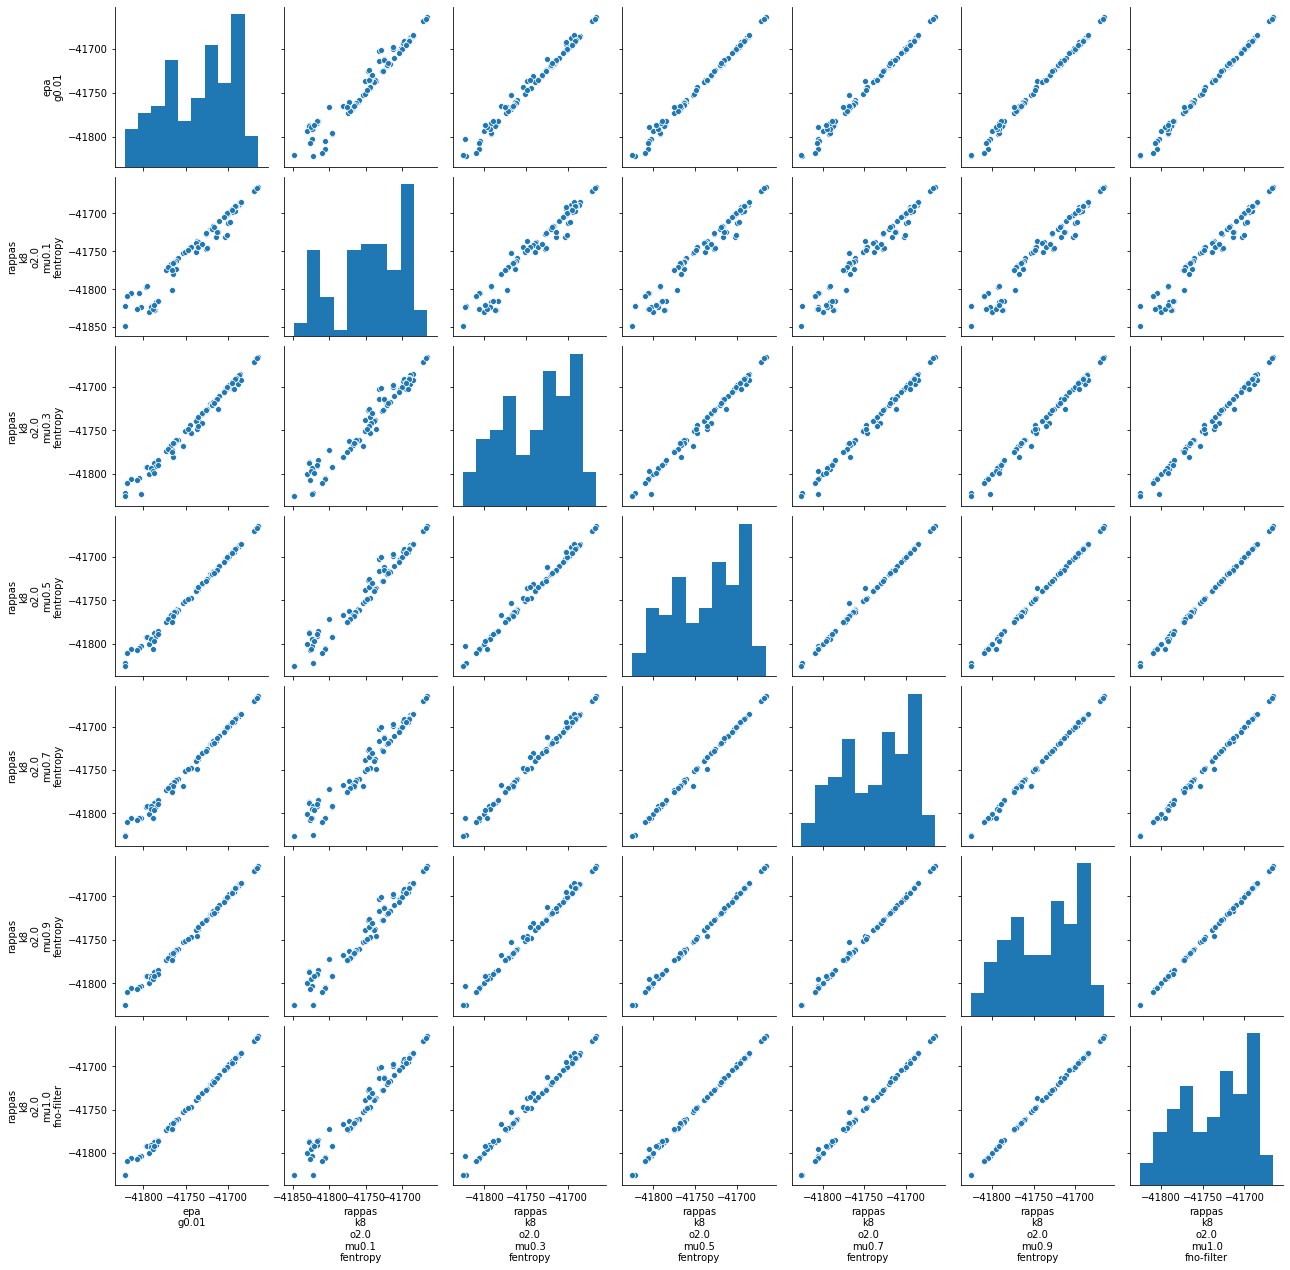

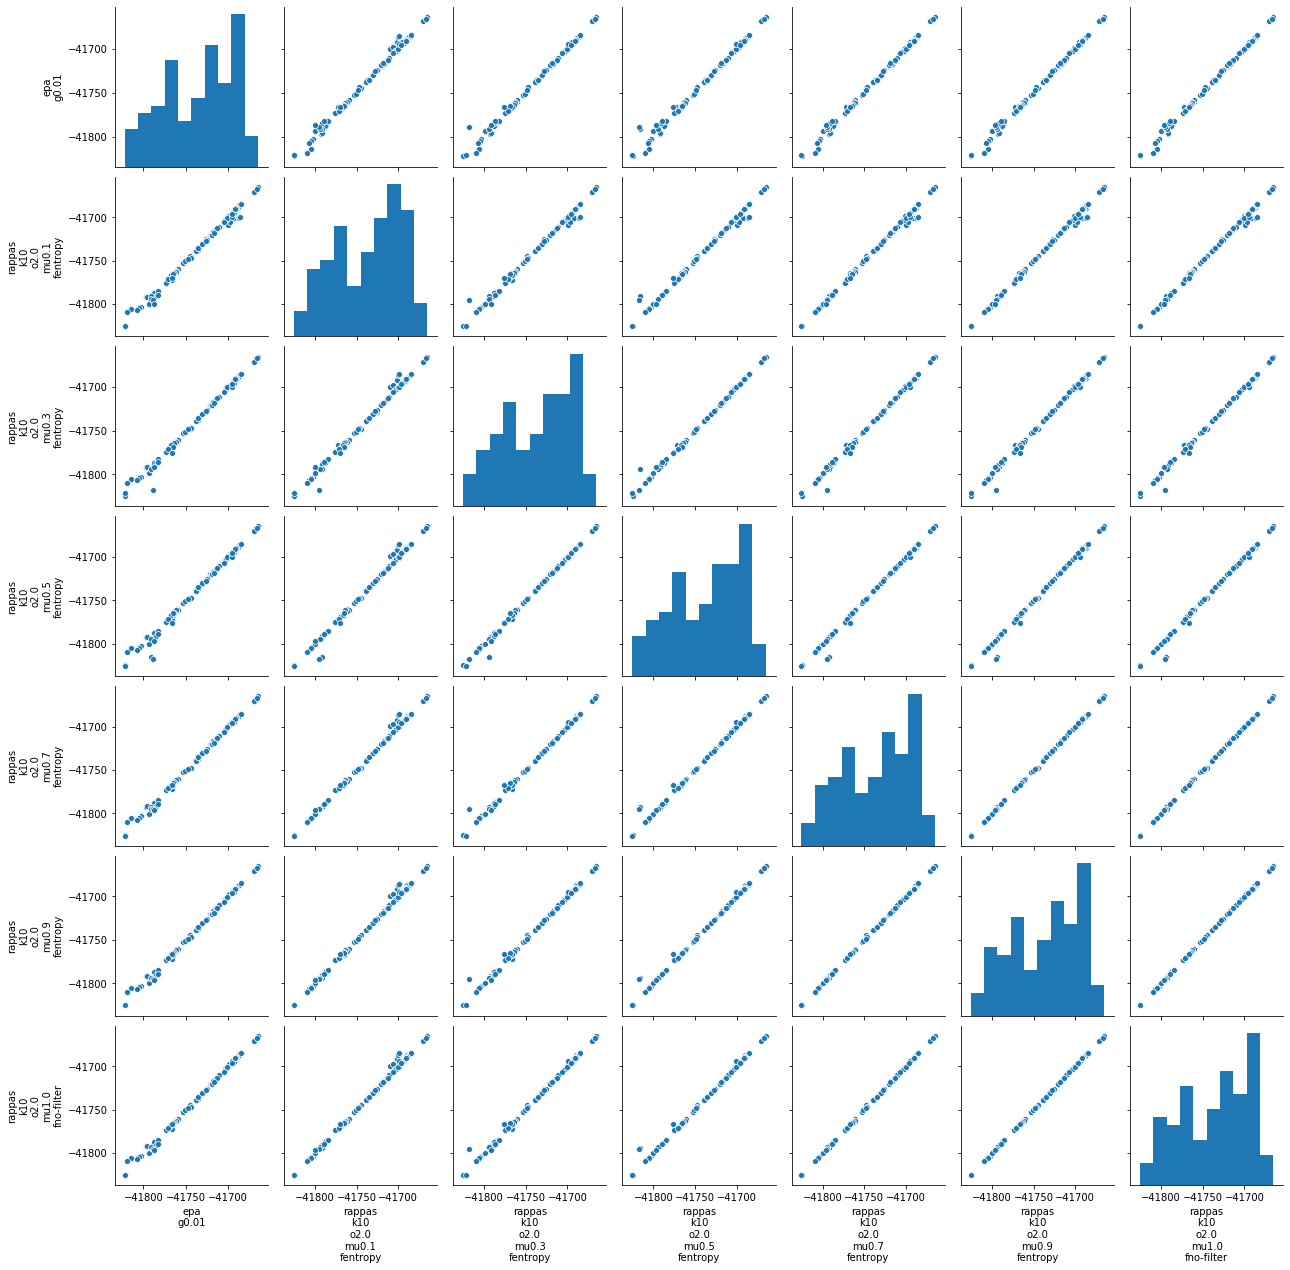

In [12]:
# Build LL-plots
for k in k_values:
    df_k_all = pd.concat([df_epa, df_k_rappas[k], df_k_rappas_full[k]], axis=1, sort=False)
    sns.pairplot(df_k_all)

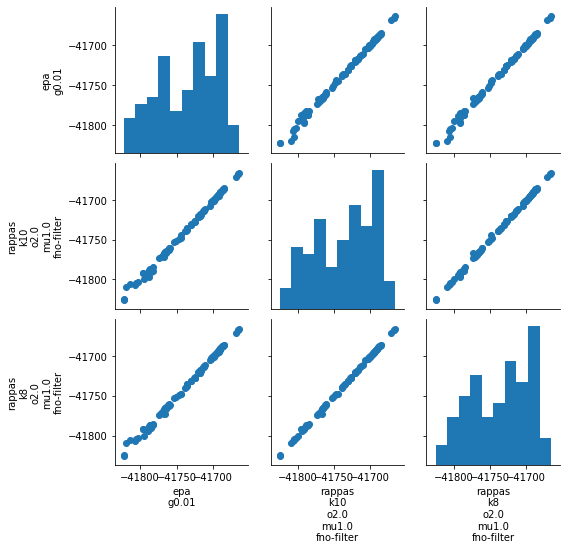

In [13]:
g = sns.pairplot(pd.concat([df_epa, df_rappas_full], axis=1, sort=False))
g = g.map_offdiag(plt.scatter)

In [46]:
g = sns.FacetGrid(tips, col="sex", hue="smoker")
g.map(plt.scatter, "total_bill", "tip", alpha=.7)
g.add_legend();

NameError: name 'x' is not defined

In [14]:
def my_scatter(x, y):

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

NameError: name 'ax' is not defined

NameError: name 'ax' is not defined

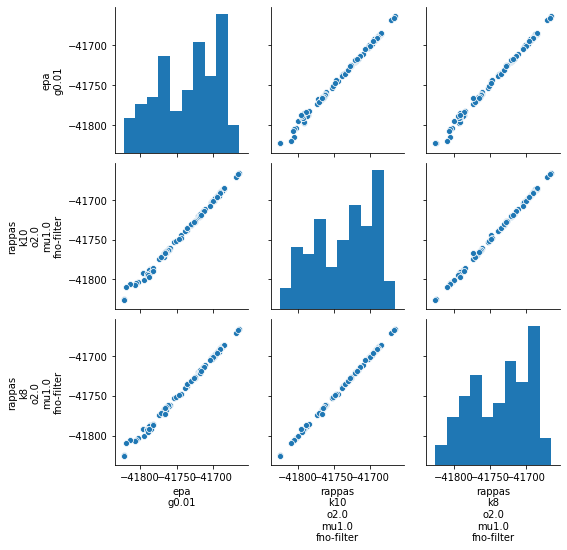

In [18]:
def my_scatter(x, y, **kwargs):
    #fig, ax = plt.subplots()
    ax.scatter(x, y-x, c='green')#, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
    #print(x)
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(x, y, 'k--', alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

g = sns.pairplot(pd.concat([df_epa, df_rappas_full], axis=1, sort=False))
g = g.map_offdiag(my_scatter)

#g = g.map_diag(my_scatter)
g

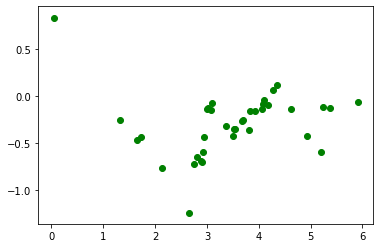

In [91]:
fig, ax = plt.subplots()
ax.scatter(x, y-x, c='green')#, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)


In [10]:
# Calculate likelihood difference for every column of the dataset
# against the baseline column
def plot_likelihood_diff(df, baseline):
    
    # make sure that indexes (the number and order of queries) are the same
    assert(all(df.index == baseline.index))
    
    # take the difference
    diff = df.sub(np.array(baseline), axis=0)
    return sns.catplot(data=diff, palette="muted", height=8, aspect=12/8)

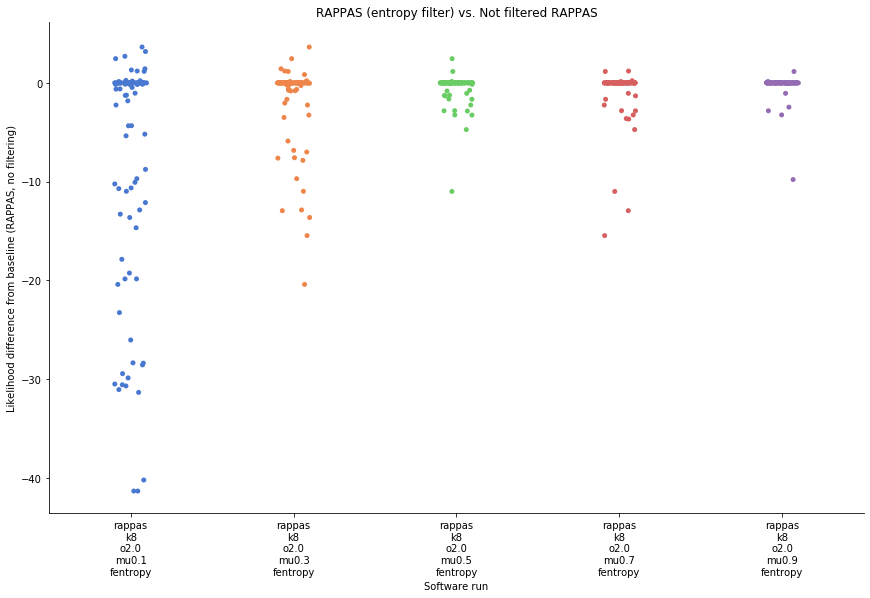

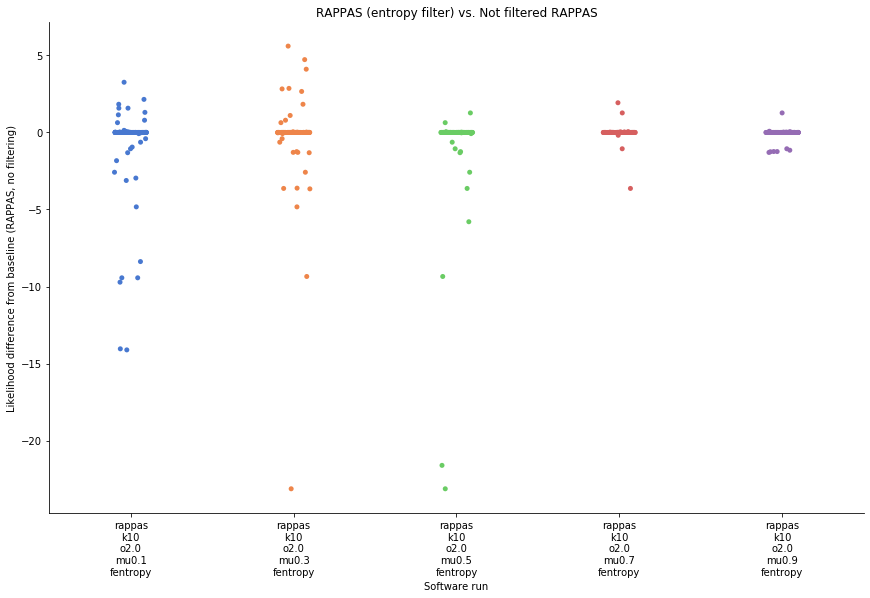

In [11]:
# Compare to the RAPPAS baseline
for k in k_values:
    g = plot_likelihood_diff(df_k_rappas[k], df_k_rappas_full[k])
    g.set(xlabel="Software run",
          ylabel="Likelihood difference from baseline (RAPPAS, no filtering)",
          title="RAPPAS (entropy filter) vs. Not filtered RAPPAS")

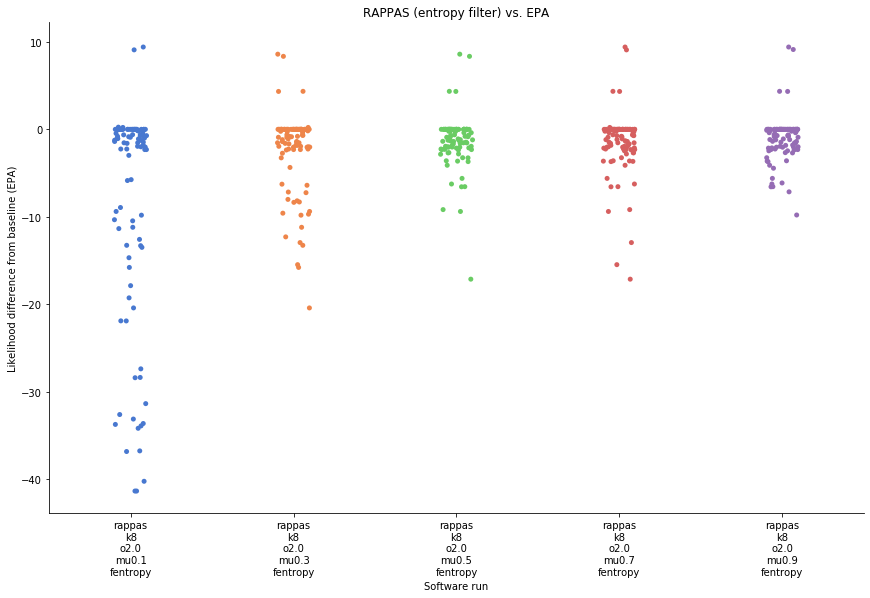

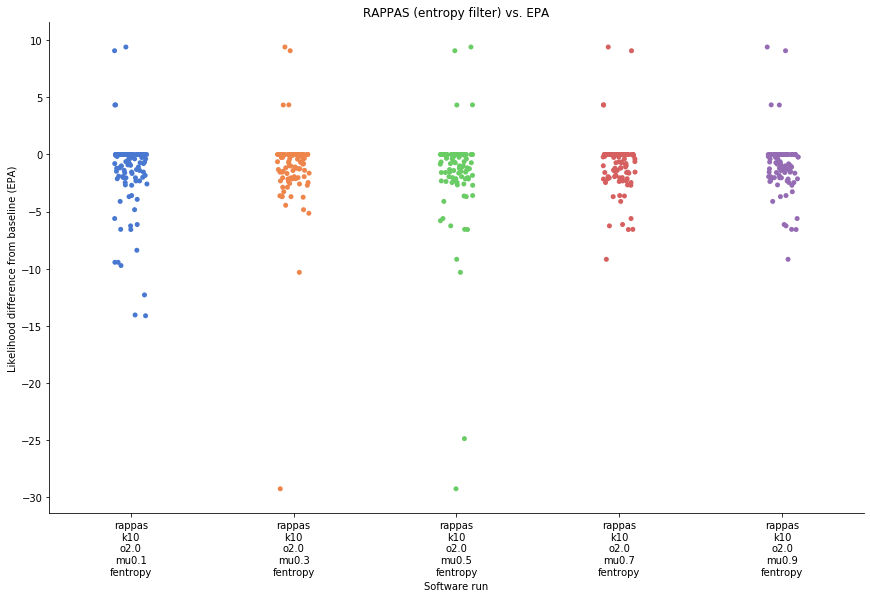

In [12]:
# Compare to EPA
for k in k_values:
    g = plot_likelihood_diff(df_k_rappas[k], df_epa)
    g.set(xlabel="Software run",
          ylabel="Likelihood difference from baseline (EPA)",
          title="RAPPAS (entropy filter) vs. EPA")

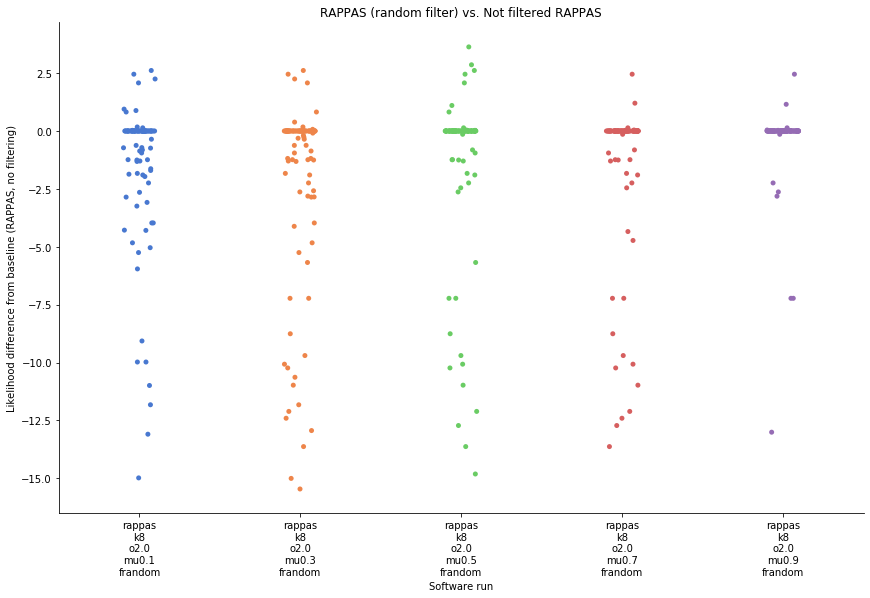

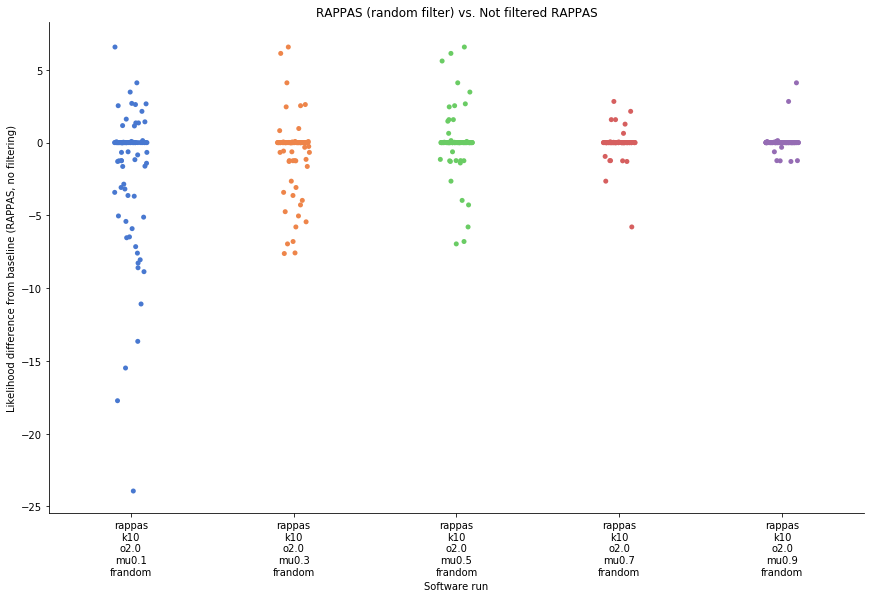

In [13]:
# Compare to the RAPPAS baseline
for k in k_values:
    g = plot_likelihood_diff(df_k_rappas_random[k], df_k_rappas_full[k])
    g.set(xlabel="Software run",
          ylabel="Likelihood difference from baseline (RAPPAS, no filtering)",
          title="RAPPAS (random filter) vs. Not filtered RAPPAS")

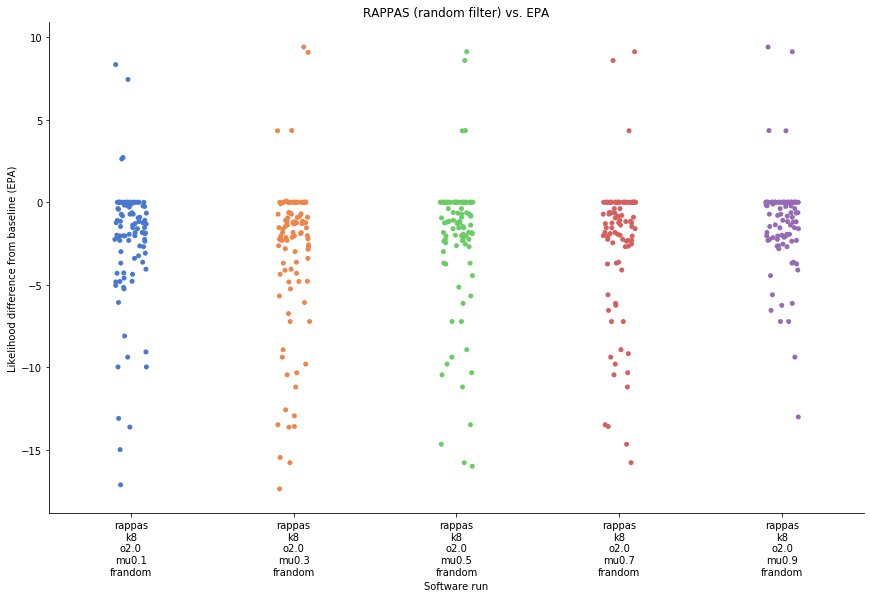

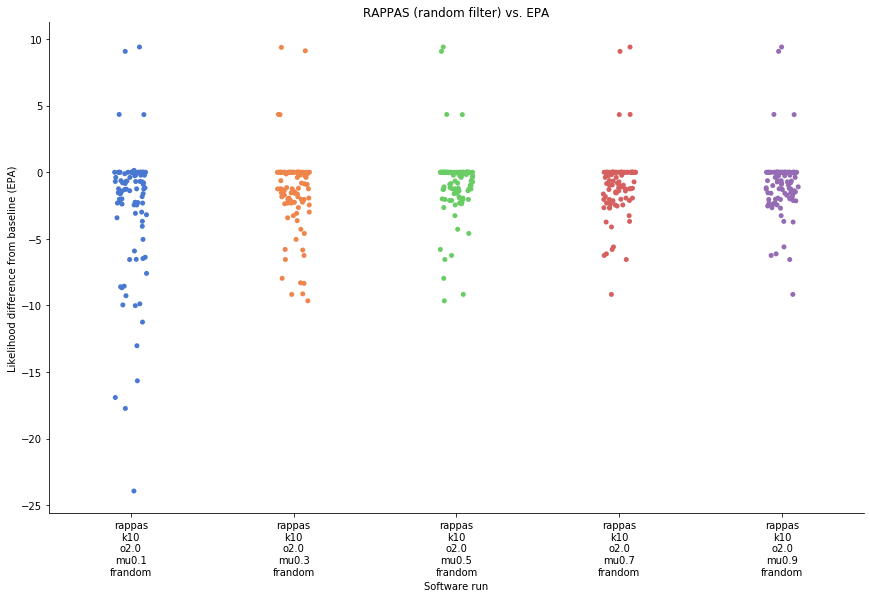

In [14]:
# Compare to EPA
for k in k_values:
    g = plot_likelihood_diff(df_k_rappas_random[k], df_epa)
    g.set(xlabel="Software run",
          ylabel="Likelihood difference from baseline (EPA)",
          title="RAPPAS (random filter) vs. EPA")

## Max deviation filter

This function calculates the maximum deviation from the mean value.

$F(P_x) = \max_{i=0}^{n}{|p_i^x - \overline {P_x}|}$

In [17]:
workdir = "/home/nikolai/dev/datasets/d652/266_pruning/pewo_likelihood_dev"
filename = f"{workdir}/summary_table_LL_rappas2.csv"
df_rappas_maxdev = pd.read_csv(filename, sep=";")
df_rappas_maxdev["software"] = "rappas"
df_rappas_maxdev.head()

,length,k,o,red,ar,mu,likelihood,software
0,0,8,2,0.99,PHYML,0.1,-41742.913409,rappas
1,0,10,2,0.99,PHYML,0.1,-41736.014309,rappas
2,0,8,2,0.99,PHYML,0.3,-41737.022266,rappas
3,0,10,2,0.99,PHYML,0.3,-41735.894070,rappas
4,0,8,2,0.99,PHYML,0.5,-41735.962155,rappas


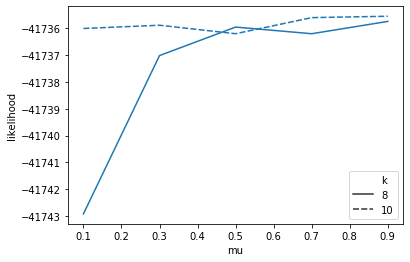

In [18]:
sns.lineplot(x="mu", y="likelihood", data=df_rappas_maxdev, style="k")

In [19]:
filename = f"{workdir}/tables_LL_rappas2.csv"
tables_rappas_dev = pd.read_csv(filename, sep=";")
tables_rappas_dev["software"] = "rappas"
tables_rappas_dev.head()

,pruning,red,ar,k,o,mu,query,length,likelihood,software
0,0,0.99,PHYML,10,2.0,0.1,113S1-4-r300-0-300,0,-41760.711894,rappas
1,0,0.99,PHYML,10,2.0,0.1,113S1-4-r300-300-600,0,-41667.159348,rappas
2,0,0.99,PHYML,10,2.0,0.1,113S1-4-r300-600-900,0,-41713.163195,rappas
3,0,0.99,PHYML,10,2.0,0.1,123B-13-F-r300-0-300,0,-41786.493945,rappas
4,0,0.99,PHYML,10,2.0,0.1,123B-13-F-r300-1200-1500,0,-41792.242213,rappas


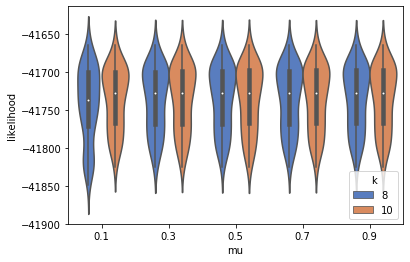

In [20]:
sns.violinplot(x="mu", y="likelihood", hue="k", data=tables_rappas_dev, palette="muted")

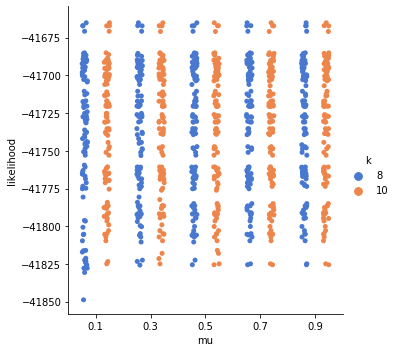

In [21]:
sns.catplot(x="mu", y="likelihood", dodge=True, hue="k", data=tables_rappas_dev, palette="muted")

In [22]:
df_all_maxdev = pd.concat([df_epa, df_rappas_maxdev], sort=False)
df_all_maxdev[:5]

,epa\ng0.01,length,k,o,red,ar,mu,likelihood,software
113S1-4-r300-0-300,-41760.711894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113S1-4-r300-300-600,-41665.623969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113S1-4-r300-600-900,-41711.922133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123B-13-F-r300-0-300,-41786.493945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123B-13-F-r300-1200-1500,-41796.585136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
tables_all = pd.concat([tables_epa, tables_rappas_dev], sort=False)
tables_all.head()

,pruning,g,query,length,likelihood,software,red,ar,k,o,mu
0,0,0.01,113S1-4-r300-0-300,0,-41760.711894,epa,NaN,NaN,NaN,NaN,NaN
1,0,0.01,113S1-4-r300-300-600,0,-41665.623969,epa,NaN,NaN,NaN,NaN,NaN
2,0,0.01,113S1-4-r300-600-900,0,-41711.922133,epa,NaN,NaN,NaN,NaN,NaN
3,0,0.01,123B-13-F-r300-0-300,0,-41786.493945,epa,NaN,NaN,NaN,NaN,NaN
4,0,0.01,123B-13-F-r300-1200-1500,0,-41796.585136,epa,NaN,NaN,NaN,NaN,NaN


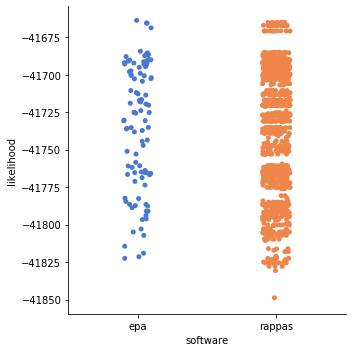

In [41]:
sns.catplot(x="software", y="likelihood", dodge=True, data=tables_all, palette="muted")

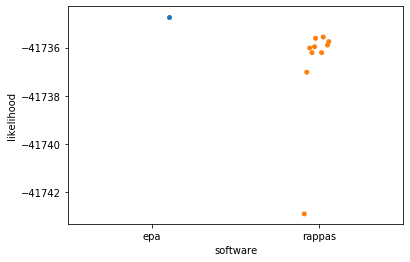

In [42]:
sns.stripplot(x="software", y="likelihood", data=df_all_maxdev)

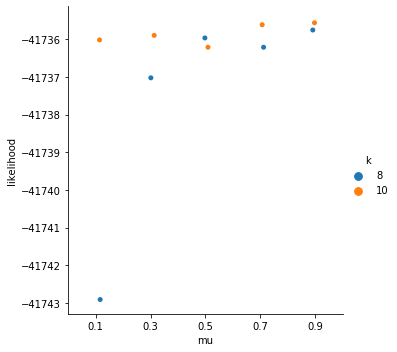

In [32]:
sns.catplot(x="mu", y="likelihood", hue="k", data=df_rappas_maxdev)